#### Antibiotic Drug Discovery
#### Corey J Sinnott
# Drug Discovery Model Evaluation and Feature Extraction

## Executive Summary

This report was commissioned to determine a robust, fast, and reproducible means of searching for, and developing, new antibiotics, in an effort to combat antibiotic resistance. After in-depth analysis, conclusions and recommendations will be presented.
   
Data was obtained from the following source:
- Comprehensive Antibiotic Resistance Database via CARD CLI interface: 
 - https://card.mcmaster.ca
- ChEMBL via Python client library: 
 - https://www.ebi.ac.uk/chembl/ 

**Full Executive Summary, Conclusion, Recommendations, Data Dictionary and Sources can be found in README.**

## Contents:
- [Data Import & Cleaning](#Data-Import-&-Cleaning)
- [Model Evaluation](#Model-Evaluation)
- [Feature Importances](#Feature-Importances)
- [Feature Extraction](#Feature-Extraction)

#### Importing Libraries

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score,\
                            precision_score, recall_score, roc_auc_score,\
                            mean_squared_error, mean_absolute_error, r2_score,\
                            plot_confusion_matrix, classification_report, \
                            plot_roc_curve, f1_score
from sklearn.feature_selection import VarianceThreshold
from sklearn import set_config
from sklearn import tree
from dtreeviz.trees import dtreeviz, explain_prediction_path
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from sklearn.inspection import permutation_importance
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

### Data Import and Preparation

In [2]:
df = pd.read_csv('./data/acinetobacter_baumannii_MIC_addFeats_addBits.csv').drop(columns = 
                        'Unnamed: 0').drop_duplicates(subset = ['canonical_smiles'])

In [3]:
df.shape

(4137, 2057)

In [4]:
df.sample(3)

,canonical_smiles,standard_value,bioactivity_binary,bioactivity_binary_class,bioactivity_multiclass,mol_wt,log_p,proton_donors,proton_acceptors,Bit_0,...,Bit_2038,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047
9119,NC(=O)c1ccc(I)c([N+](=O)[O-])c1,20000.0,inactive,0,inactive,292.032,1.2983,1.0,3.0,0,...,0,0,0,0,0,0,0,0,0,0
6338,CC(C)CC1NC(=O)C(C(=O)NCCCC(=O)N[C@@H](C(=O)N[C...,100.0,inactive,0,intermediate,615.709,0.7286,6.0,8.0,0,...,0,0,0,0,0,0,0,0,0,0
4161,Nc1ncc(-c2ccc(NC(=O)c3cc(F)cc(F)c3)cc2)[nH]1,200000.0,inactive,0,inactive,314.295,3.1894,3.0,3.0,0,...,0,0,0,1,0,0,0,0,0,0


Creating a scaled target

In [5]:
df['pMIC'] = df['standard_value'].map(lambda x: -np.log10(x * (10**-9)))

In [6]:
#first test with subset not containing intermediate efficacy
df_bin_class = df[df.bioactivity_multiclass != 'intermediate']

In [7]:
df_bin_class.bioactivity_multiclass.value_counts()

inactive    1618
active      1092
Name: bioactivity_multiclass, dtype: int64

# Model Evaluation

## Classification

In [8]:
X_c = df_bin_class.drop(columns = ['canonical_smiles','standard_value',
                             'bioactivity_binary','bioactivity_binary_class',
                             'bioactivity_multiclass', 'pMIC'])
y_c = df_bin_class['bioactivity_binary_class']

In [9]:
ss = StandardScaler()
num_cols = ['mol_wt', 'log_p', 'proton_donors', 'proton_acceptors']
X_c[num_cols] = ss.fit_transform(X_c[num_cols])

In [10]:
def classification_and_eval(X, y, model):
    """
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    model = model
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f'null accuracy = {round(max(y_test.mean(), 1 - y_test.mean()), 3)}')
    print(f'    accuracy  = {np.round(accuracy_score(y_test, y_pred), 3)}')
    print(f'    precision = {np.round(precision_score(y_test, y_pred), 3)}')
    print(f'    recall    = {np.round(recall_score(y_test, y_pred), 3)}')
    print(f'    f1-score  = {np.round(f1_score(y_test, y_pred), 3)}')
    print(f'    roc auc   = {np.round(roc_auc_score(y_test, y_pred), 3)}')
    
    return model, X_test, y_test, y_pred

In [132]:
c_model, X_test_c, y_test_c, y_pred_c = classification_and_eval(X_c, y_c, 
                                        HistGradientBoostingClassifier(max_iter = 800, 
                                                               verbose = 0))

null accuracy = 0.6
    accuracy  = 0.975
    precision = 0.964
    recall    = 0.974
    f1-score  = 0.969
    roc auc   = 0.975


In [20]:
c_model, X_test_c, y_test_c, y_pred_c = classification_and_eval(X_c, y_c, 
                                        RandomForestClassifier(n_jobs = -1, 
                                                               verbose = 0))

null accuracy = 0.591
    accuracy  = 0.945
    precision = 0.984
    recall    = 0.881
    f1-score  = 0.93
    roc auc   = 0.935


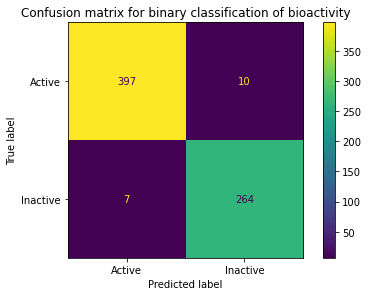

In [133]:
plot_confusion_matrix(c_model, X_test_c, y_test_c, display_labels = ['Active', 'Inactive']);
plt.tight_layout();
plt.title('Confusion matrix for binary classification of bioactivity');

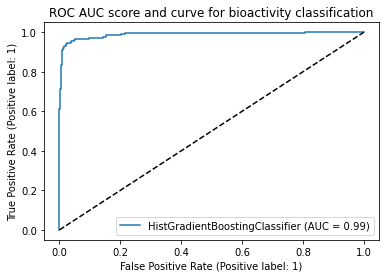

In [17]:
plot_roc_curve(c_model, X_test_c, y_test_c)
plt.title('ROC AUC score and curve for bioactivity classification');
plt.plot([0,1], [0,1], 'k--')
plt.show();

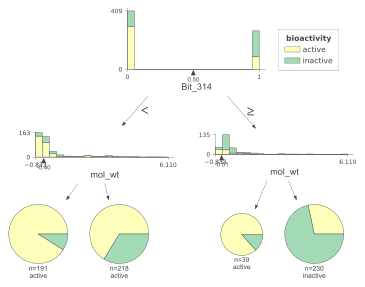

In [18]:
# https://github.com/parrt/dtreeviz
# not compatible with random forest
# much lower accuracy
X_train, X_test, y_train, y_test = train_test_split(X_c, y_c)
classifier = tree.DecisionTreeClassifier(max_depth=2)  # limit depth of tree
classifier.fit(X_train, y_train)

viz = dtreeviz(classifier, 
               X_test,
               y_test,
               target_name='bioactivity',
               feature_names = X_c.columns, 
               class_names=["active", "inactive"], 
               histtype= 'barstacked')  # barstackes is default
viz

# Feature Importances

In [21]:
feature_import_df = pd.DataFrame(c_model.feature_importances_, 
                                   index =X_c.columns,  
                                   columns=['importance']).sort_values('importance', 
                                                                       ascending=False)

In [22]:
feature_import_df[0:15]

,importance
mol_wt,0.026185
proton_acceptors,0.017946
proton_donors,0.017372
log_p,0.012171
Bit_314,0.011029
Bit_388,0.008199
Bit_1395,0.008033
Bit_1608,0.007766
Bit_2000,0.007376
Bit_351,0.007328


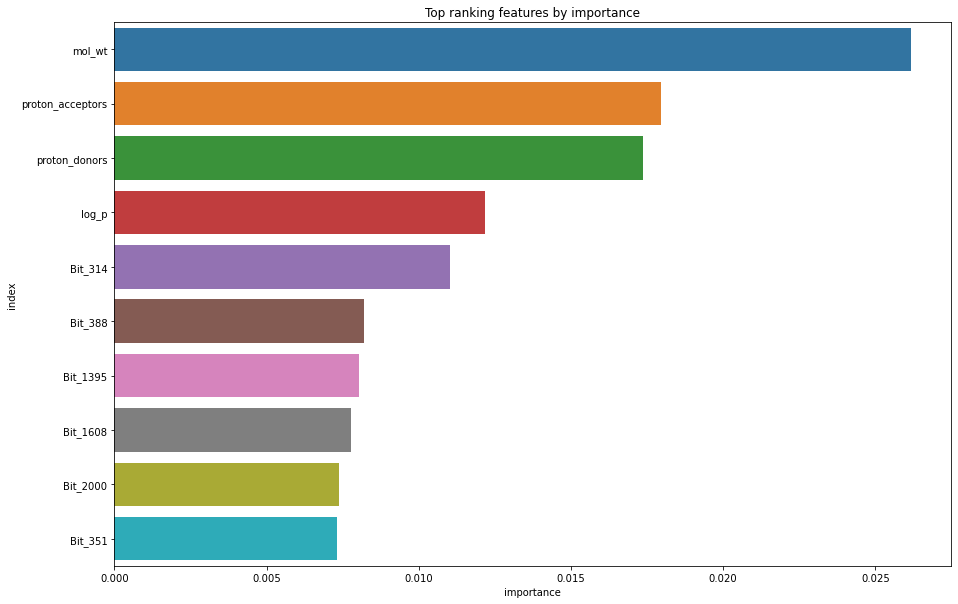

In [23]:
graph_feat_importance = feature_import_df.reset_index(col_fill = 'feature')

plt.figure(figsize=(15, 10))
x = graph_feat_importance['importance'].head(10)
y = graph_feat_importance['index'].head(10)
sns.barplot(x = x, y = y).set_title('Top ranking features by importance');

# Feature Extraction

#### Bit 314

In [23]:
bit_314s = df[df.Bit_314 == 1]

In [24]:
bit_314s.shape

(1618, 2058)

In [128]:
bit_314s.sort_values(by = 'pMIC', ascending = False).head(3)

,canonical_smiles,standard_value,bioactivity_binary,bioactivity_binary_class,bioactivity_multiclass,mol_wt,log_p,proton_donors,proton_acceptors,Bit_0,...,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047,pMIC
2475,N[C@@H]1CCCCN(c2c(F)cc3c(=O)c(C(=O)O)cn(C4CC4)...,0.015,active,1,active,393.846,3.1447,2.0,5.0,1,...,0,0,0,0,0,0,0,0,0,10.823909
3708,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,0.016,active,1,active,558.563,0.2924,6.0,10.0,0,...,0,0,0,0,0,0,0,0,0,10.795880
3710,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,0.016,active,1,active,544.536,-0.0977,6.0,10.0,0,...,0,0,0,0,0,0,0,0,0,10.795880


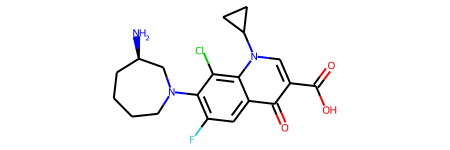

In [59]:
#mol_1 produces error
mol_1 = Chem.MolFromSmiles(bit_314s.canonical_smiles[2475]) 
mol_1

In [65]:
mol_2 = Chem.MolFromSmiles(bit_314s.canonical_smiles[3708]) 

In [79]:
bi = {}
vect = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol_2, radius=2, bitInfo=bi)
# show 10 of the set bits:
list(vect.GetOnBits())[:20]

[140,
 202,
 231,
 253,
 309,
 314,
 354,
 361,
 423,
 432,
 446,
 486,
 519,
 525,
 531,
 562,
 585,
 650,
 658,
 673]

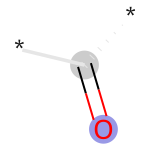

In [75]:
Draw.DrawMorganBit(mol_2, 314, bi)

In [83]:
# produces more errors than images
def bit_checker(mol, vect):
    for i in vect:
        try:
            [Draw.DrawMorganBit(mol, i, bi) for i in list(vect.GetOnBits())]
        except:
            pass
        
    return

In [86]:
bit_388s = df[df.Bit_388 == 1]

In [88]:
bit_388s.sort_values(by = 'pMIC', ascending = False).head(3)

,canonical_smiles,standard_value,bioactivity_binary,bioactivity_binary_class,bioactivity_multiclass,mol_wt,log_p,proton_donors,proton_acceptors,Bit_0,...,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047,pMIC
5296,COc1ccc2ccc(F)c(C[C@H](N)[C@@H]3CC[C@@H](NCc4c...,0.03,active,1,active,481.528,2.3156,3.0,8.0,0,...,0,0,0,0,0,0,0,0,0,10.522879
5297,COc1ccc2ccc(=O)n(C[C@H](O)[C@@H]3CC[C@@H](NCc4...,0.03,active,1,active,481.509,0.8293,3.0,10.0,0,...,0,0,0,0,0,0,0,0,0,10.522879
3358,c1cc2cc(-c3ccc(-c4cc5ccc(C6=NCCN6)cc5[nH]4)cc3...,0.06,active,1,active,444.542,4.6828,4.0,4.0,0,...,0,0,0,0,0,0,0,0,0,10.221849


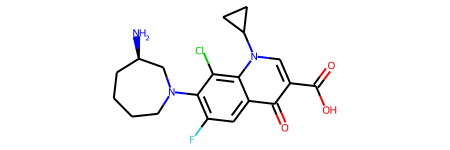

In [59]:
mol_1 = Chem.MolFromSmiles(bit_314s.canonical_smiles[2475]) 
mol_1

In [65]:
mol_2 = Chem.MolFromSmiles(bit_314s.canonical_smiles[3708]) 

In [79]:
bi = {}
vect = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol_2, radius=2, bitInfo=bi)
# show 10 of the set bits:
list(vect.GetOnBits())[:20]

[140,
 202,
 231,
 253,
 309,
 314,
 354,
 361,
 423,
 432,
 446,
 486,
 519,
 525,
 531,
 562,
 585,
 650,
 658,
 673]

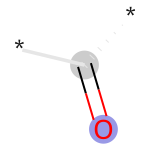

In [75]:
Draw.DrawMorganBit(mol_2, 314, bi)

#### Bit 388

In [86]:
bit_388s = df[df.Bit_388 == 1]

In [88]:
bit_388s.sort_values(by = 'pMIC', ascending = False).head(3)

,canonical_smiles,standard_value,bioactivity_binary,bioactivity_binary_class,bioactivity_multiclass,mol_wt,log_p,proton_donors,proton_acceptors,Bit_0,...,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047,pMIC
5296,COc1ccc2ccc(F)c(C[C@H](N)[C@@H]3CC[C@@H](NCc4c...,0.03,active,1,active,481.528,2.3156,3.0,8.0,0,...,0,0,0,0,0,0,0,0,0,10.522879
5297,COc1ccc2ccc(=O)n(C[C@H](O)[C@@H]3CC[C@@H](NCc4...,0.03,active,1,active,481.509,0.8293,3.0,10.0,0,...,0,0,0,0,0,0,0,0,0,10.522879
3358,c1cc2cc(-c3ccc(-c4cc5ccc(C6=NCCN6)cc5[nH]4)cc3...,0.06,active,1,active,444.542,4.6828,4.0,4.0,0,...,0,0,0,0,0,0,0,0,0,10.221849


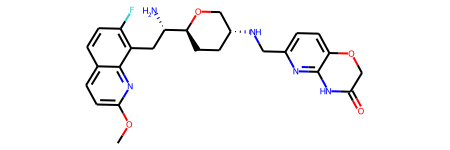

In [90]:
#mol_1 produces error
mol = Chem.MolFromSmiles(bit_314s.canonical_smiles[5296]) 
mol

In [92]:
bi = {}
vect = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi)
# show 10 of the set bits:
list(vect.GetOnBits())[:10]

[1, 9, 24, 79, 80, 118, 126, 203, 216, 255]

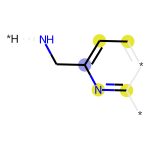

In [93]:
Draw.DrawMorganBit(mol, 388, bi)

Bit 1395

In [94]:
bit_1395s = df[df.Bit_1395 == 1]

In [95]:
bit_1395s.sort_values(by = 'pMIC', ascending = False).head(3)

,canonical_smiles,standard_value,bioactivity_binary,bioactivity_binary_class,bioactivity_multiclass,mol_wt,log_p,proton_donors,proton_acceptors,Bit_0,...,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047,pMIC
3708,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,0.0160,active,1,active,558.563,0.2924,6.0,10.0,0,...,0,0,0,0,0,0,0,0,0,10.795880
3710,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,0.0160,active,1,active,544.536,-0.0977,6.0,10.0,0,...,0,0,0,0,0,0,0,0,0,10.795880
3686,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,0.0312,active,1,active,558.563,0.2940,6.0,10.0,0,...,0,0,0,0,0,0,0,0,0,10.505845


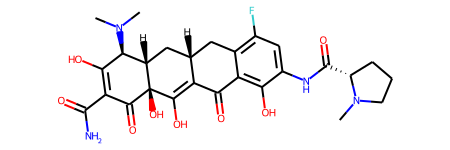

In [97]:
mol = Chem.MolFromSmiles(bit_1395s.canonical_smiles[3708]) 
mol

In [98]:
bi = {}
vect = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi)
# show 10 of the set bits:
list(vect.GetOnBits())[:10]

[140, 202, 231, 253, 309, 314, 354, 361, 423, 432]

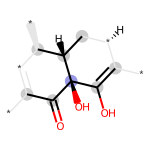

In [99]:
Draw.DrawMorganBit(mol, 1395, bi)

Bit 1608

In [100]:
bit_1608s = df[df.Bit_1608 == 1]

In [101]:
bit_1608s.sort_values(by = 'pMIC', ascending = False).head(3)

,canonical_smiles,standard_value,bioactivity_binary,bioactivity_binary_class,bioactivity_multiclass,mol_wt,log_p,proton_donors,proton_acceptors,Bit_0,...,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047,pMIC
4422,NC1CC1COc1ccc2ncc(F)c(CCC34CCC(NCc5ccc6c(n5)NC...,0.25,active,1,active,548.619,3.02500,3.0,9.0,0,...,0,0,0,0,0,0,0,0,0,9.60206
4323,O=c1ccc2ncc(F)c3c2n1C[C@@]3(O)CC12CCC(NC/C=C/c...,0.25,active,1,active,497.517,3.78990,2.0,6.0,0,...,0,0,0,0,0,0,0,0,0,9.60206
4205,Cc1cc(=O)n2c3c(c(F)cnc13)[C@](O)(CC13CCC(NCc4c...,0.50,active,1,active,521.549,2.03282,3.0,9.0,0,...,0,0,0,0,0,0,0,0,0,9.30103


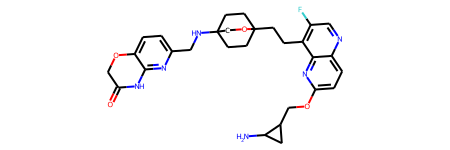

In [102]:
mol = Chem.MolFromSmiles(bit_1608s.canonical_smiles[4422]) 
mol

In [103]:
bi = {}
vect = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi)
# show 10 of the set bits:
list(vect.GetOnBits())[:10]

[59, 70, 80, 116, 168, 226, 251, 255, 290, 314]

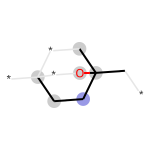

In [104]:
Draw.DrawMorganBit(mol, 1608, bi)

In [127]:
# from http://rdkit.blogspot.com/2018/10/using-new-fingerprint-bit-rendering-code.html
from ipywidgets import interact, fixed, IntSlider
def renderFpBit(mol, bitIdx, bitInfo, fn):
    bid = bitIdx
    
    return(display(fn(mol,bid,bitInfo)))

In [129]:
mol = Chem.MolFromSmiles(bit_1608s.canonical_smiles[4422]) 

In [130]:
bi = {}
vect = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi)
# show 10 of the set bits:
list(vect.GetOnBits())[:10]

[59, 70, 80, 116, 168, 226, 251, 255, 290, 314]

In [131]:
interact(renderFpBit, bitIdx=list(bi.keys()),mol=fixed(mol),
         bitInfo=fixed(bi),fn=fixed(Draw.DrawMorganBit));
#interactive widget may not push to GitHub

interactive(children=(Dropdown(description='bitIdx', options=(59, 70, 80, 116, 168, 226, 251, 255, 290, 314, 3…